In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import models
from config import opt
import torch
import torch.nn as nn
from tqdm import tqdm
from torchnet import meter
from utils.visualize import Visualizer
from data import Data_utility

In [2]:
df_train = pd.read_csv('./raw_data/train_data.csv')
df_test = pd.read_csv('./raw_data/test_data.csv')

In [16]:
df = pd.concat([df_train,df_test],axis=0)

In [17]:
df.to_csv('./raw_data/all_data.csv',index=False)

假设对2010-01-01预测

处理数据

In [3]:
history_data = pd.concat([df_train[df_train['date']=='2009-12-31'],df_test[df_test['date']=='2010-01-01']],axis=0).copy()
history_data.reset_index(inplace=True,drop=True)
history_data.drop(columns=['date'],inplace=True)
history_data[['Power']] = scaler.transform(history_data[['Power']])

In [4]:
scaler = joblib.load('scaler.pkl')

In [8]:
history_data

,month,day,weekday,hour,max_T,min_T,avg_T,D,Power
0,12,31,3,0.0,21.50,16.90,18.70,75.0,-0.856113
1,12,31,3,0.5,21.50,16.65,18.55,74.0,-1.020160
2,12,31,3,1.0,21.50,16.40,18.40,73.0,-1.219504
3,12,31,3,1.5,21.50,16.30,18.35,72.5,-1.445103
4,12,31,3,2.0,21.50,16.20,18.30,72.0,-1.636063
...,...,...,...,...,...,...,...,...,...
91,1,1,4,21.5,24.95,19.00,21.15,69.5,-0.403644
92,1,1,4,22.0,24.80,19.00,21.10,70.0,-0.437670
93,1,1,4,22.5,24.70,19.00,21.05,70.5,-0.497697
94,1,1,4,23.0,24.60,19.00,21.00,71.0,-0.616814


In [9]:
model = models.WaveNet(opt.input_size,opt.out_size,opt.residual_size,
                       opt.skip_size,opt.dilation_cycles,opt.dilation_depth)

In [10]:
model.load('./models/checkpoints/WaveNet9.pth')

仅预测下半小时情况

In [71]:
preds = []
with torch.no_grad():
    model.eval()
    for i in range(48):
        inputs = torch.from_numpy(history_data[i:i+48].values).unsqueeze(0)
        inputs = inputs.type(torch.FloatTensor)
        pred = model(inputs)
        preds.append(pred[-1,-1,-1].item())

In [78]:
true_label = scaler.inverse_transform(history_data[48:][['Power']])

In [80]:
pred_label = scaler.inverse_transform(preds)

In [87]:
true_label = true_label.reshape(-1)

In [96]:
mape = (np.abs(pred_label-true_label)/true_label).mean()*100

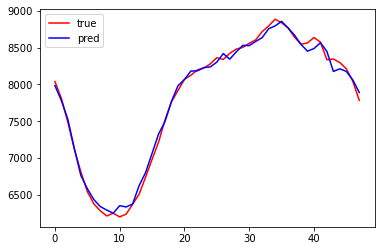

In [90]:
plt.plot(true_label,c='r',label='true')
plt.plot(pred_label,c='b',label='pred')
plt.legend(loc='best')
plt.show()

若一整天滚动预测

In [100]:
inputs.shape

torch.Size([1, 48, 9])

In [101]:
rol_history_data = history_data.copy()

In [114]:
rol_preds = []
with torch.no_grad():
    model.eval()
    for i in range(48):
        inputs = torch.from_numpy(rol_history_data[i:i+48].values).unsqueeze(0)
        inputs = inputs.type(torch.FloatTensor)
        pred = model(inputs)
        rol_preds.append(pred[-1,-1,-1].item())
        rol_history_data.loc[i+48,'Power'] = pred[-1,-1,-1].item()

In [116]:
rol_pred_label = scaler.inverse_transform(rol_preds)

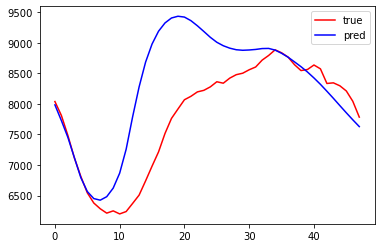

In [118]:
plt.plot(true_label,c='r',label='true')
plt.plot(rol_pred_label,c='b',label='pred')
plt.legend(loc='best')
plt.show()

In [119]:
mape = (np.abs(rol_pred_label-true_label)/true_label).mean()*100

In [120]:
mape

7.828210643133729

假设短时预测前再训练？

取30天数据再训练

对2010-01-01预测,则取三十天前

In [3]:
df = pd.read_csv('./raw_data/all_data.csv')

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.set_index('date',inplace=True)

In [6]:
train_data = df['2010-12-01':'2010-12-31']

In [7]:
train_data.reset_index(inplace=True)

In [8]:
len(train_data)

1488

In [10]:
data_utility = Data_utility(train_data,opt.WINDOW_SIZE,scaler=scaler)

In [12]:
X,Y = data_utility.get_data()

In [14]:
model = models.WaveNet(opt.input_size,opt.out_size,opt.residual_size,
                       opt.skip_size,opt.dilation_cycles,opt.dilation_depth)
model.load('./models/checkpoints/WaveNet9.pth')

In [15]:
device = torch.device('cuda') if opt.use_gpu else torch.device('cpu')

In [16]:
model.to(device)

WaveNet(
  (input_conv): CausalConv1d(
    (conv1): Conv1d(9, 3, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (dilated_stacks): ModuleList(
    (0): DilatedStack(
      (residual_stack): ModuleList(
        (0): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
          (skipconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_si

In [17]:
criterion = nn.MSELoss()
lr = opt.lr
optimizer = model.get_optimizer(lr,opt.weight_decay)
loss_meter = meter.AverageValueMeter()
previous_loss = 1e10

In [18]:
model.train()

WaveNet(
  (input_conv): CausalConv1d(
    (conv1): Conv1d(9, 3, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (dilated_stacks): ModuleList(
    (0): DilatedStack(
      (residual_stack): ModuleList(
        (0): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
          (skipconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_si

In [21]:
vis = Visualizer(opt.env,port=opt.vis_port)

Setting up a new session...
Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


再训练

In [22]:
for epoch in range(opt.max_epoch):
        loss_meter.reset()
        for i,(data,label) in tqdm(enumerate(data_utility.get_batches(X,Y,opt.batch_size,shuffle=False))):
            
            inputs = data.to(device)
            targets = label.to(device)
            
            optimizer.zero_grad()
            preds = model(inputs)
            preds = preds.squeeze(2)
            loss = criterion(preds,targets)
            loss.backward()
            optimizer.step()
            
            loss_meter.add(loss.item())
            if(i+1)%opt.print_freq == 0:
                vis.plot('loss',loss_meter.value()[0])
        
        if loss_meter.value()[0]>previous_loss:
            lr = lr * opt.lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
        previous_loss = loss_meter.value()[0]

44it [00:18,  2.37it/s]
44it [00:01, 38.39it/s]
44it [00:01, 40.70it/s]
44it [00:01, 41.12it/s]
44it [00:01, 41.31it/s]
44it [00:01, 40.82it/s]
44it [00:01, 39.78it/s]
44it [00:01, 40.33it/s]
44it [00:01, 41.08it/s]
44it [00:01, 40.33it/s]


In [26]:
history_data = df['2009-12-31':'2010-01-01'].copy()

In [28]:
history_data.reset_index(inplace=True,drop=True)

In [31]:
history_data[['Power']] = scaler.transform(history_data[['Power']])

In [38]:
model.to('cpu')

WaveNet(
  (input_conv): CausalConv1d(
    (conv1): Conv1d(9, 3, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (dilated_stacks): ModuleList(
    (0): DilatedStack(
      (residual_stack): ModuleList(
        (0): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(1,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
          (skipconv1_1): Conv1d(3, 3, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualLayer(
          (conv_filter): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (conv_gate): CausalConv1d(
            (conv1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          )
          (resconv1_1): Conv1d(3, 3, kernel_si

In [39]:
preds = []
with torch.no_grad():
    model.eval()
    for i in range(48):
        inputs = torch.from_numpy(history_data[i:i+48].values).unsqueeze(0)
        inputs = inputs.type(torch.FloatTensor)
        pred = model(inputs)
        preds.append(pred[-1,-1,-1].item())

In [42]:
true_label = scaler.inverse_transform(history_data[48:][['Power']])
pred_label = scaler.inverse_transform(preds)
true_label = true_label.reshape(-1)

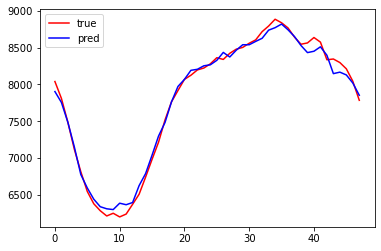

In [43]:
plt.plot(true_label,c='r',label='true')
plt.plot(pred_label,c='b',label='pred')
plt.legend(loc='best')
plt.show()

In [50]:
mape = (np.abs(pred_label-true_label)/true_label).mean()*100

In [51]:
mape

0.8154447774738947

若一整天滚动预测

In [44]:
rol_history_data = history_data.copy()

In [45]:
rol_preds = []
with torch.no_grad():
    model.eval()
    for i in range(48):
        inputs = torch.from_numpy(rol_history_data[i:i+48].values).unsqueeze(0)
        inputs = inputs.type(torch.FloatTensor)
        pred = model(inputs)
        rol_preds.append(pred[-1,-1,-1].item())
        rol_history_data.loc[i+48,'Power'] = pred[-1,-1,-1].item()

In [46]:
rol_pred_label = scaler.inverse_transform(rol_preds)

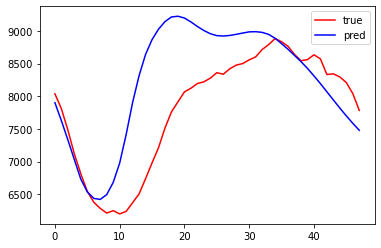

In [47]:
plt.plot(true_label,c='r',label='true')
plt.plot(rol_pred_label,c='b',label='pred')
plt.legend(loc='best')
plt.show()

In [48]:
mape = (np.abs(rol_pred_label-true_label)/true_label).mean()*100